**Installing necessary libraries**

In [ ]:
!sudo apt install tesseract-ocr -y
!sudo apt install libtesseract-dev -y
!sudo apt-get install poppler-utils -y

In [ ]:
! pip install langchain langchain-openai faiss-cpu langchain_community langchain_experimental open_clip_torch torch unstructured[all-docs] PyMuPDF python-Levenshtein

In [24]:
%matplotlib inline
import os
from PIL import Image
from langchain.vectorstores import FAISS
from langchain_experimental.open_clip import OpenCLIPEmbeddings
from langchain_openai import OpenAI,OpenAIEmbeddings,ChatOpenAI
from langchain.chains import LLMChain,RetrievalQA,create_extraction_chain
from langchain_core.messages import HumanMessage
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
import io
import fitz
import random
import Levenshtein
os.environ["OPENAI_API_KEY"] = ''


**Setting up the data and image paths**

In [4]:
pdf_file = "./data/bird-book.pdf"
image_set = "./data/image"
if not os.path.exists(image_set):
  os.mkdir(image_set)

**Extract and save the images**

In [5]:
pdf_file_read = fitz.open(pdf_file)
for page_index in range(len(pdf_file_read)):
    page = pdf_file_read[page_index]
    image_list = page.get_images()
    if image_list:
        for image_index, img in enumerate(image_list, start=1):
          xref = img[0]
          base_image = pdf_file_read.extract_image(xref)
          image_bytes = base_image["image"]
          image_ext = base_image["ext"]
          #image_bytes.seek(0)
          ext_set = ('jpg','jpeg','png')
          if base_image['cs-name'] == 'DeviceRGB' and image_ext in ext_set:
            image = Image.open(io.BytesIO(image_bytes))
            image.save(open(f"{image_set}/image{page_index+1}_{image_index}.{image_ext}", "wb"))


**Function to display images**

In [16]:
def display_image(image):
  img = Image.open(image)
  plt.imshow(img)
  plt.show()

**Displaying 5 random images from the images retrieved from the file**

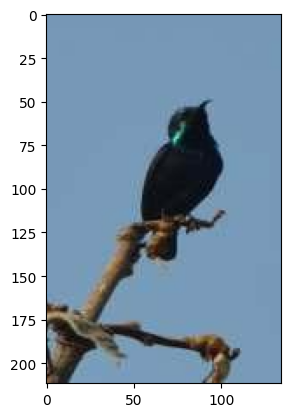

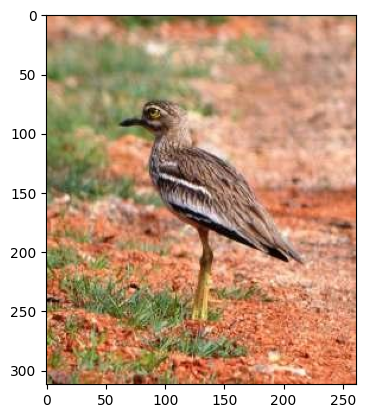

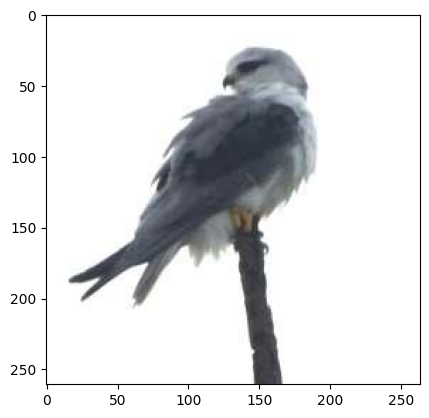

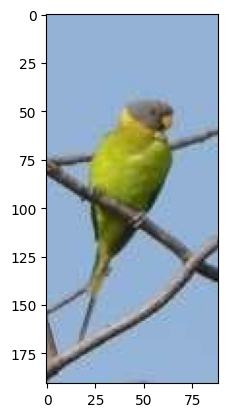

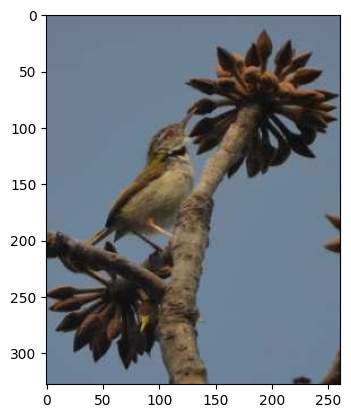

In [17]:
image_list = os.listdir(image_set)
for i in range(5):
  files = random.choice(image_list)
  files = os.path.join(image_set,files)
  display_image(files)

**Using ChatGPT4 to identify the bird and store the names of the birds with their corresponding images (in base64 format) in a dictionary**

In [ ]:
bird_dict = {}

for filename in os.listdir(image_set):
  img_file = os.path.join(image_set,filename)
  with open(img_file, "rb") as image_file:
    x = base64.b64encode(image_file.read()).decode("utf-8")

  chat = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=1024)

  response = chat.invoke(
          [
              HumanMessage(
                  content=[
                      {"type": "text",
                       "text": "Identify the bird in less than 5 words. If the image is not of a bird, reply with 'Unknown'"
                       },
                      {
                          "type": "image_url",
                          "image_url": {"url": f"data:image/jpeg;base64,{x}"},
                      },
                  ]
              )
          ]
      )
  name = response.content
  if name in bird_dict:
    bird_dict[name].append(x)
  else:
    bird_dict[name] = [x]


**List of birds with a count of number of images per entry**

In [19]:
for key, value in sorted(bird_dict.items()):
  print(key, len([item for item in value if item]))

Black Kite 1
Black-headed Ibis 1
Black-naped Monarch 1
Blue-tailed Bee-eater 1
Blue-tailed Bee-eater. 1
Brahminy Starling 1
Chestnut-headed Bee-eater. 1
Common Kestrel. 1
Common Kingfisher. 1
Double-crested Cormorant 1
Eastern Screech Owl. 1
Eurasian coot. 1
Great Egret 1
Great Hornbill. 1
Green Bee-eater. 1
Indian Pitta 1
Indian Robin. 1
Laughing Dove. 1
Laughing Gull 1
Mississippi Kite 1
Northern Pintail Duck 1
Oriental Pied Hornbill. 1
Plain Prinia 1
Plum-headed Parakeet 1
Red-throated barbet. 1
Red-wattled Lapwing 1
Ruddy Shelduck 1
Scaly-breasted munia 1
Spot-billed Pelican. 1
Spotted Owlet 1
Unknown 3
Yellow-footed Green Pigeon. 1


**Loading the data to query textual information from it**

In [43]:
loader = PyPDFLoader(pdf_file)
docs = loader.load_and_split()
model = "gpt-3.5-turbo-1106"
text_splitter = RecursiveCharacterTextSplitter(
                                    chunk_size = 2000,
                                    chunk_overlap = 200,
                                    length_function = len
                                    )
data = text_splitter.split_documents(docs)
embeddings = OpenAIEmbeddings()
vector_db = FAISS.from_documents(data,embeddings)
llm = ChatOpenAI(model=model)
chain = RetrievalQA.from_llm(llm = llm,
                             retriever = vector_db.as_retriever()
                              )

**Defining a function to get the species of the bird.**

1. With the chain created from the chat model with the vector database, I would use RAG to answer user queries.
2. I am using keyword extraction to find the exact name of the bird species.
3. Next, I am using Levenshtein distance to match the output of keyword extraction with the keys in my bird dictionary.
4. Finally, I am displaying result of the user's query alongwith the relevant pictures.

In [21]:
def get_species(species):
  closest_distance = float('inf')
  closest_keyword = None
  for key in bird_dict.keys():
    keyword_list = key.split()
    for keyword in keyword_list:
      distance = Levenshtein.distance(keyword, species)
      if distance < closest_distance:
        closest_distance = distance
        closest_keyword = " ".join(keyword_list)
  return closest_keyword

In [56]:
def querying(query):
  response = chain.invoke(query)["result"]
  print(response)
  schema = {
    "properties": {
        "name": {"type": "string"}
    },
    "required": ["name"],
    }

  keyword = create_extraction_chain(schema, llm)
  ans = f"""
          {response}
        """
  species = keyword.run(ans)[0]['name']
  species = get_species(species)

  for pics in bird_dict[species]:
    pics = io.BytesIO(base64.b64decode(pics))
    display_image(pics)

What do you know about Flycatcher?
The flycatcher is a bird with various species, including the Tickell's Flycatcher and the Asian Paradise-Flycatcher. The Tickell's Flycatcher has a blue upper part with an orange throat and breast for the male, while the female has greyish-blue upper parts and a pale orange throat. The Asian Paradise-Flycatcher has a black head and crest for both male and female, with different colors and lengths of tail for each gender. Unfortunately, I don't have information about the specific behaviors or habits of these flycatcher species.


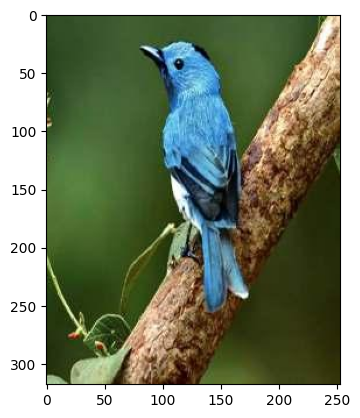

None



Tell me about parakeet birds 
Parakeets are small to medium-sized parrots with long tail feathers. There are different types of parakeets, such as the Alexandrine Parakeet, Rose-Ringed Parakeet, and Plum-Headed Parakeet. Each type has distinct physical characteristics, such as size, coloration, and markings. For example, the Alexandrine Parakeet has a green head with a red beak and a pink collar in the neck, while the Rose-Ringed Parakeet has a similar appearance but is smaller and lacks a red patch in the scapular. The Plum-Headed Parakeet, on the other hand, has a red head with a black prominent collar in males, while females have a light grey head with yellowish green underparts. These parakeets are known for their vibrant colors and are popular as pets due to their social nature and ability to mimic sounds.


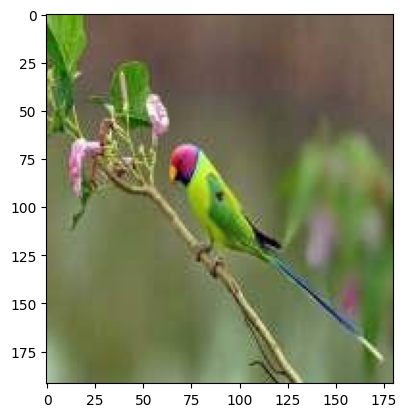

None



What can you tell me about owlets ?
Owlets are small birds, typically around 20cm in size. They have a barred pattern on their upper and underparts, with rufous barring on their wings. They also have a pale whitish color near the throat that spreads across the belly in the underparts.


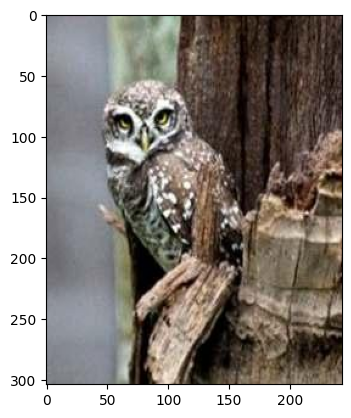

None



Which bird has black head with red beak?
The bird with a black head and a red beak is the male Red Avadavat.


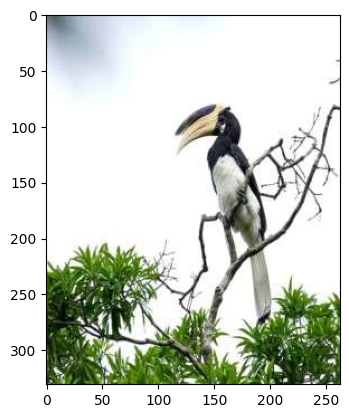

None





In [57]:
query_list = [
    "What do you know about Flycatcher?",
    "Tell me about parakeet birds ",
    "What can you tell me about owlets ?",
    "Which bird has black head with red beak?"
        ]
for questions in query_list:
  print(questions)
  print(querying(questions))
  print("\n\n")